# Show a few prototype examples of how the owl database for pyiron can be used

Aim: Demonstrate in two example how an ontology (including a reasoner) can be used to 

- automatically construct workflows
- automatically search databases

### Imports and helper functions/definitions

In [1]:
import owlready2 as owl
import pandas as pd
import numpy as np
from pyiron import Project

In [2]:
onto = owl.get_ontology("file://pyiron_labels.owl").load() 

In [3]:
Bulkmodulus = onto.Bulk_modulus
VASP = onto.VASP
LAMMPS = onto.LAMMPS
lblAtomistic = onto.Atomistic
lblUserInput = onto.UserInput
Executable = onto.Executable

def consistent_output(self, additional_conditions=None):
        if additional_conditions is None:
            conditions = self.has_conditions  # + self.has_transitive_conditions
        else:
            conditions = additional_conditions
        # print ('conditions: ', conditions)    
        if len(conditions) > 0:    
            return [p for p in self.generic_parameter[0].has_parameters if is_subset(conditions, p.has_options)]
            # return list(set.intersection(*map(set,[i.has_optional_objects for i in conditions])))
        return self.generic_parameter[0].has_parameters
    
def is_subset(a, b):
    return np.all([aa in b for aa in a])   

#### First steps in using the ontology

In [13]:
onto.Bulk_modulus.has_parameters[0].output_of[0].mandatory_input[0].generic_parameter[0].has_parameters

[pyiron_labels.CreateStructureBulk,
 pyiron_labels.VASP,
 pyiron_labels.LAMMPS,
 pyiron_labels.Murnaghan/ref_job,
 pyiron_labels.CreateSurface,
 pyiron_labels.Murnaghan]

In [14]:
ref_job = Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0]

In [15]:
ref_job.generic_parameter[0].has_parameters

([pyiron_labels.Bulk3dStructure, pyiron_labels.AtomisticEnergyCalculator],
 [pyiron_labels.CreateStructureBulk,
  pyiron_labels.VASP,
  pyiron_labels.LAMMPS,
  pyiron_labels.Murnaghan/ref_job,
  pyiron_labels.CreateSurface,
  pyiron_labels.Murnaghan])

In [16]:
consistent_output(ref_job)

[pyiron_labels.VASP, pyiron_labels.LAMMPS]

In [7]:
list(onto.individuals());

In [10]:
onto.Bulk_modulus.domain, onto.Bulk_modulus.has_parameters

([pyiron_labels.MaterialProperty],
 [pyiron_labels.Murnaghan/output/equilibrium_bulk_modulus])

In [11]:
Bulkmodulus.has_parameters[0].generic_parameter

[pyiron_labels.Bulk_modulus]

In [12]:
Bulkmodulus.has_parameters[0].generic_parameter

[pyiron_labels.Bulk_modulus]

In [13]:
VASP.input

[pyiron_labels.ENCUT, pyiron_labels.IBRAV]

In [14]:
inp = Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0]
inp

pyiron_labels.Murnaghan/ref_job

In [15]:
LAMMPS.mandatory_input

[pyiron_labels.LAMMPS/input/structure]

In [16]:
Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0]

pyiron_labels.Murnaghan/ref_job

In [17]:
consistent_output(Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0])

[pyiron_labels.VASP, pyiron_labels.LAMMPS]

In [18]:
lblAtomistic.has_objects

[pyiron_labels.CreateStructureBulk,
 pyiron_labels.VASP,
 pyiron_labels.LAMMPS,
 pyiron_labels.AtomicStructure,
 pyiron_labels.ChemicalElement,
 pyiron_labels.CreateSurface,
 pyiron_labels.Murnaghan]

In [19]:
consistent_output(VASP.mandatory_input[0])

[pyiron_labels.LAMMPS/input/structure,
 pyiron_labels.CreateStructureBulk/output/structure,
 pyiron_labels.CreateSurface/output/structure,
 pyiron_labels.VASP/input/structure]

In [20]:
Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0].has_conditions

[pyiron_labels.Bulk3dStructure, pyiron_labels.AtomisticEnergyCalculator]

In [21]:
inp = consistent_output(Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0])[0].mandatory_input[0]
consistent_output(inp, inp.has_transitive_conditions)

[pyiron_labels.CreateStructureBulk/output/structure]

In [22]:
onto['LAMMPS/input/structure'].has_transitive_conditions

[pyiron_labels.Bulk3dStructure]

In [23]:
consistent_output(consistent_output(Bulkmodulus.has_parameters[0].output_of[0].mandatory_input[0])[0].mandatory_input[0])

[pyiron_labels.LAMMPS/input/structure,
 pyiron_labels.CreateStructureBulk/output/structure,
 pyiron_labels.CreateSurface/output/structure,
 pyiron_labels.VASP/input/structure]

### Automatically construct workflows

Start from the target quantity (e.g. onto.Bulk_modulus) and let the ontology construct a workflow to automatically compute it 

In [35]:
out = onto.Bulk_modulus.has_parameters[0]  # alternative: onto.B_prime
df_dict = {'source': [], 'target': [], 'operator': []}
for i in range(100):
    # print ('out: ', out.name)
    if out.generic_parameter[0] == Executable:
        inp = out.mandatory_input[0]
        code = None
        # print (f'i: {inp.name} -> o:{out.name}')
    else:
        code = out.output_of[0]
        inp = code.mandatory_input[0]
        # print (f'i:{inp.name} -> c:{code.name} -> o:{out.name}')
    if i==0:    
        conditions = np.array(inp.has_conditions)
    else:
        conditions = np.array(list(conditions) + inp.has_conditions)
        conditions = conditions[np.in1d(conditions, inp.has_transitive_conditions)]
    # print ('conditions', conditions)
    if code is None:
        print (f'i: {inp.name} -> o:{out.name}  c:{conditions}')
    else:
        print (f'i:{inp.name} -> c:{code.name} -> o:{out.name}  c:{conditions}')  
    df_dict['source'].append(inp.name)
    df_dict['target'].append(out.name)
    df_dict['operator'].append(code)
    
    if lblUserInput in inp.generic_parameter[0].domain: break    

    out = consistent_output(inp, conditions)
    if len(out) != 1:
        print ('WARNING: More than one matching output! ', out)
    out = out[0]    
  
df = pd.DataFrame(df_dict) 

i:Murnaghan/ref_job -> c:Murnaghan -> o:Murnaghan/output/equilibrium_bulk_modulus  c:[pyiron_labels.Bulk3dStructure pyiron_labels.AtomisticEnergyCalculator]
i: VASP/input/structure -> o:VASP  c:[pyiron_labels.Bulk3dStructure]
i:CreateStructureBulk/input/element -> c:CreateStructureBulk -> o:CreateStructureBulk/output/structure  c:[]


In [36]:
df

,source,target,operator
0,Murnaghan/ref_job,Murnaghan/output/equilibrium_bulk_modulus,pyiron_labels.Murnaghan
1,VASP/input/structure,VASP,None
2,CreateStructureBulk/input/element,CreateStructureBulk/output/structure,pyiron_labels.CreateStructureBulk


#### Visualize workflow

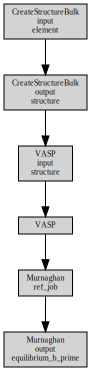

In [23]:
import graphviz

target = ['\n'.join(t.split('/')) for t in df.target.values]
source = ['\n'.join(t.split('/')) for t in df.source.values]
my_lst = np.array([source[::-1], target[::-1]]).T.flatten()
To = my_lst[1:]
From = my_lst[:-1]

node_attr = dict(style='filled',
                 shape='box',
                 align='left',
                 fontsize='8',
                 ranksep='0.1',
                 height='0.2')
w = graphviz.Digraph(node_attr=node_attr)
w.edges((f, t) for f,t in zip(From, To))
w

#### Towards a fully recursive creation of workflows (fragment)

In [28]:
def get_new_output(out, conditions=[]):
    if out.generic_parameter[0] == Executable:
        inp = out.mandatory_input[0]
        code = None
        # print (f'i: {inp.name} -> o:{out.name}')
    else:
        code = out.output_of[0]
        inp = code.mandatory_input[0]
        # print (f'i:{inp.name} -> c:{code.name} -> o:{out.name}')
    # if i==0:    
    #     conditions = np.array(inp.has_conditions)
    # else:
    conditions = np.array(list(conditions) + inp.has_conditions)
    # conditions = conditions[np.in1d(conditions, inp.has_transitive_conditions)]
    print ('transitive: ', inp.has_transitive_conditions)

    if code is None:
        print (f'i: {inp.name} -> o:{out.name}  c:{conditions}')
    else:
        print (f'i:{inp.name} -> c:{code.name} -> o:{out.name}  c:{conditions}')  
    df_dict['source'].append(inp.name)
    df_dict['target'].append(out.name)
    df_dict['operator'].append(code)
    
    if lblUserInput in inp.generic_parameter[0].domain: 
        return [], []

    out = consistent_output(inp, conditions)
    # if len(out) != 1:
    #     print ('WARNING: More than one matching output! ', out)
    conditions = conditions[np.in1d(conditions, inp.has_transitive_conditions)]
    return out, conditions

In [29]:
def get_all_paths(node, path=None, c=[]):
    paths = []
    if path is None:
        path = []
    path.append(node)
    children, c = get_new_output(node, c)[0]
    if len(children):
        for child in children:
            paths.extend(get_all_paths(child, path[:]))
    else:
        paths.append(path)
    return paths

In [30]:
out = Bulkmodulus.has_parameters[0]
df_dict = {'source': [], 'target': [], 'operator': []}
# conditions = []
# get_all_paths(out)
o, c = get_new_output(out, conditions=[])
get_new_output(o[0], c)

transitive:  []
i:Murnaghan/ref_job -> c:Murnaghan -> o:Murnaghan/output/equilibrium_bulk_modulus  c:[pyiron_labels.Bulk3dStructure pyiron_labels.AtomisticEnergyCalculator]
transitive:  [pyiron_labels.Bulk3dStructure]
i: VASP/input/structure -> o:VASP  c:[]


([pyiron_labels.LAMMPS/input/structure,
  pyiron_labels.CreateStructureBulk/output/structure,
  pyiron_labels.CreateSurface/output/structure,
  pyiron_labels.VASP/input/structure],
 array([], dtype=float64))

In [31]:
# def run_recursive(out, conditions):
#     if len(out) == 0:
#         return None
#     for i, o in enumerate(out):
#         print (i)
        
#         o_new, c_new = get_new_output(o, conditions)

In [32]:
# out = [Bulkmodulus.has_parameters[0]]
# df_dict = {'source': [], 'target': [], 'operator': []}
# conditions = []
# run_recursive(out, conditions)

# for ind_o, o in enumerate(out):
#     for i in range(5):
#         print (i, ind_o)
#         out, conditions = get_new_output(out, conditions)

## Use Ontology to access pyiron database

### Definitions and helper tools

In [24]:
def get_ref_job(job):
    ref_job_name = list(set(job.project_hdf5.list_groups()) - set(['input', 'output']))
    if len(ref_job_name) == 1:
        return ref_job_name[0]

In [25]:
def get_job_type(job):
    ref_job_name = get_ref_job(job)
    if ref_job_name is not None:
        return job[f'{ref_job_name}/TYPE'].split('.')[-1][:-2]

In [26]:
def alloy(el):
    if el is None:
        return '%'
    return f'%{el}%'  # convert to SQL search string

In [27]:
import pint
ureg = pint.UnitRegistry()

def convert_unit(my_parameter):
    if hasattr(my_parameter, "unit"):
        source_unit = my_parameter.unit
        if len(source_unit) == 1:            
            target_unit = my_parameter.generic_parameter[0].unit[0]
            # print (source_unit, target_unit)
            if source_unit[0] != target_unit:
                return ureg(source_unit[0]).to(target_unit).magnitude
        elif len(source_unit) > 1:
            print (source_unit)
            raise ValueError('Multiple units not supported')
    return 1

In [28]:
def find_property(my_property, project, select_alloy=None):
    specific_property = my_property.has_parameters[0]
    job_type = specific_property.output_of[0].name
    hdf_path = '/'.join(specific_property.name.split('/')[1:])

    pd_header = ['Chemical Formula', f'{my_property.name} [{my_property.unit[0]}]', 'ref_job']
    pd_dic = {k:[] for k in pd_header}
    sql_formula_str = alloy(select_alloy)
    df_murn = pd.DataFrame(project.db.get_items_dict({'hamilton': job_type, 'chemicalformula': sql_formula_str}))
    for _, row in df_murn.iterrows():
        if row.projectpath[-1] == '/':
            job = pr.inspect(row.id)
            pd_dic['Chemical Formula'].append(row.chemicalformula)
            cv = convert_unit(specific_property)
            pd_dic[pd_header[1]].append(cv * job[hdf_path])
            pd_dic['ref_job'].append(get_job_type(job))
    return pd.DataFrame(pd_dic)        

### Application

Use ontology to automatically search pyiron database. 

In [29]:
pr = Project('../../..')

In [30]:
onto.MaterialProperty.has_objects

[pyiron_labels.Bulk_modulus, pyiron_labels.B_prime]

In [32]:
%%time
find_property(onto.Bulk_modulus, pr, select_alloy='Ni')

CPU times: user 61.5 ms, sys: 6.21 ms, total: 67.8 ms
Wall time: 424 ms


,Chemical Formula,Bulk_modulus [MPa],ref_job
0,Ni500,185513.288349,Lammps
1,Al300Ni200,230375.100288,Lammps
2,Al150Ni350,160828.564398,Lammps
3,Al250Ni250,254207.487861,Lammps
4,Al50Ni450,183825.580752,Lammps
5,Al100Ni400,173273.260765,Lammps
6,Al200Ni300,153863.670694,Lammps
7,Al450Ni50,90651.343840,Lammps
8,Al350Ni150,202765.139146,Lammps
9,Al400Ni100,126690.387263,Lammps


In [33]:
find_property(onto.B_prime, pr)

,Chemical Formula,B_prime [1],ref_job
0,Cu4,5.693501,Lammps
1,Al4,6.263347,Lammps
2,Al2,1.367559,Lammps
3,Ni500,4.449077,Lammps
4,Al4,6.375468,Lammps
5,Cr2,4.861313,Lammps
6,Al500,4.239103,Lammps
7,Al50Ni450,3.933827,Lammps
8,Al100Ni400,3.444580,Lammps
9,Al150Ni350,3.043943,Lammps


### Old notes

Allow for more complex links between input and output
- input + constraints
- output + options

e.g.:
- input = ref_job, constraints=[Structure3DCrystal, AtomicEnergy]   -> can be labels, Parameters
- VASP, options=[AtomicStricture, Structure3DCrystal, AtomicEnergy]